In [1]:
import tensorflow as tf
import numpy as np
# Tensorflow Dist
import tensorflow_probability as tfp
tfd = tfp.distributions

from collections import deque # Used to have limited arrays

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import os
import re   #regex
import time
import datetime
#import json
#import gc # Garbage collector of Python


from datetime import datetime
from google.colab import drive
# Libs for Images
from PIL import Image
import imageio

import glob #it does pattern matching and expansion <- Retrieving filenames on system and such
#from tensorflow.keras.preprocessing.image import ImageDataGenerator


#import itertools
#from sklearn.metrics import confusion_matrix , classification_report

# Manipulate the cells output
from IPython import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 
# Easy life 
tensorboard_loaded = False


#Google Drive
drive.mount('/content/drive')
# Path settings
base_path = '/content/drive/My Drive/'
path_to_TrackGAN = base_path + 'Colab Notebooks/TrackGAN/'
# Custom Libraries Path
import sys
sys.path.append(base_path + 'Libs')


# Configure the logging
import logging 
logging.basicConfig( level=logging.DEBUG)
#logging.basicConfig(format=formatter, level=logging.DEBUG)


# Reloading Custom Libraries
import importlib

# Custom Libraries Import
import keras_utils
import keras_models
import image_utils
import train_asses
import data_utils
import custom_metrics
import datasets_manager
import keras_model_wrappers


Mounted at /content/drive


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
def rlib():
  libs = [keras_utils , keras_models , image_utils, train_asses, data_utils , custom_metrics, datasets_manager, keras_model_wrappers]
  for lib in libs:
    importlib.reload(lib)

11501568/11490434 [==============================] - 0s 0us/step
Input Shape : (70000, 28, 28, 1) 
Output Shape : (70000,)


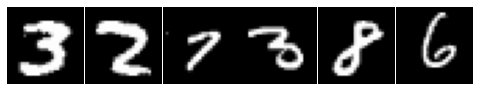

In [3]:
# Mnist 0-9 digits dataset
X_, Y_ = datasets_manager.mnist_digit_dataset()
rlib()
# Create Fake Dataset FOR TESTING RELATIVE DATA DISTRIBUTION
#X_, Y_= datasets_manager.dummy_RGB_dataset()
# Some image trasformation applied
#X_, Y_= datasets_manager.dummy_RGB_dataset_transformed()


image_utils.display_multiple_image( X_[27:33], size = [600,300])

In [4]:
BATCH_SIZE = 40
BUFFER_SIZE = X_.shape[0]
n_class = 10

training_dataset = tf.data.Dataset.from_tensor_slices( image_utils.normalize_images(X_) )
# Normalize
#training_dataset = training_dataset.map(image_utils.normalize_image)
# To One Hot
#training_dataset = training_dataset.map(train_asses.to_one_hot_encode)
# Batch and shuffle the data
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True) # In Order to have the same batch Dimension, without a repeat dataset - To change  


#valid_dataset = tf.data.Dataset.from_tensor_slices((X_[-BATCH_SIZE:],Y_[-BATCH_SIZE:]))
# Normalize
#valid_dataset = valid_dataset.map(image_utils.normalize_image)
# To One Hot
#valid_dataset = valid_dataset.map(train_asses.to_one_hot_encode)
# To Batch
#valid_dataset = valid_dataset.batch(BATCH_SIZE)


training_dataset
#print()
#valid_dataset

<BatchDataset element_spec=TensorSpec(shape=(40, 28, 28, 1), dtype=tf.float32, name=None)>

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [ ]:
for x in training_dataset:
  image_utils.display_multiple_image(x[:8] , size=[1500,2000] , denormalize=True)
  break

In [5]:
rlib()
epsilon = 1e-3

px_dist = image_utils.extract_distribution(X_ , of_type = "pixel", epsilon = 1e-3) 
channel_dist = image_utils.extract_distribution(X_ , of_type = "channel", epsilon = 1e-3)
patch_dist = image_utils.extract_distribution(X_ , of_type = "patch",epsilon = 1e-3, patch_shape= [2,2], patch_type = 'channel'  )

distributions = {"Distribution per Pixel" : px_dist , "Distribution Per Channel" : channel_dist , "Distribution Per (2,2) Patch" :  patch_dist}
distributions


{'Distribution Per (2,2) Patch': <tfp.distributions.Normal 'Normal' batch_shape=[14, 14, 1] event_shape=[] dtype=float32>,
 'Distribution Per Channel': <tfp.distributions.Normal 'Normal' batch_shape=[28, 28, 1] event_shape=[] dtype=float32>,
 'Distribution per Pixel': <tfp.distributions.Normal 'Normal' batch_shape=[28, 28] event_shape=[] dtype=float32>}

In [ ]:
rlib()
image_utils.plot_channels_dist( [channel_dist, channel_dist], image_channels = 1, title = ["Original Data Color Per Channel Distribution" , "Gen Data Color Per Channel Distribution"] )

In [ ]:
rlib()

keras_models.infogan_generator_continuous().summary()
#disc_model, q_model = keras_models.infogan_discriminator_continuous()
#disc_model.summary()
#q_model.summary()

**Discriminator loss**

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.


**Generator loss**

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [6]:
rlib()

# Disc/Gen Losses
discriminator_loss = train_asses.discriminator_BinaryCrossentropy_loss
generator_loss = train_asses.generator_BinaryCrossentropy_loss


#generator = keras_models.define_generator(latent_dim = 100, n_class = n_class)
#discriminator = keras_models.define_discriminator_rgb(n_class = n_class)
generator = keras_models.infogan_generator_continuous()
discriminator, q_model = keras_models.infogan_discriminator_continuous()


model_name = 'InfoGAN D115k-G180k'


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)


lr_dcgan = 0.0002
beta1_dcgan = 0.5
#1e-4
generator_optimizer = tf.keras.optimizers.Adam(lr_dcgan,beta_1=beta1_dcgan)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_dcgan, beta_1=beta1_dcgan)
q_optimizer = tf.keras.optimizers.Adam(lr_dcgan, beta_1=beta1_dcgan)

#generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-4)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate = 5e-4, momentum = 0.9)

#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule )


checkpoint_dir = path_to_TrackGAN + 'training_checkpoints/' + model_name
checkpoint = tf.train.Checkpoint(step=tf.Variable(1),
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 q_optimizer = q_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 q_model = q_model)


# Limit Number of checkpoints and Manage restoring
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 5 , checkpoint_name= 'tf_ckpts')


# Maybe this is the issue with tensorboard
try:
  summary_writer.close()
except: pass

# NO IDEA

# tensorboard summary
log_dir = path_to_TrackGAN + "logs/" + "fit/" + model_name 
log_dir
summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.init()

'/content/drive/My Drive/Colab Notebooks/TrackGAN/logs/fit/InfoGAN D115k-G180k'

In [7]:
rlib()

noise_dim = 62
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)

# Seeds locations
seed_save_path = base_path + 'DATA_Rep/infoGAN.npy'
cond_seed_save_path = base_path + 'DATA_Rep/rgb_cond_seed2.npy'

# Restore or create a new noise seed
#noise_seed = train_asses.get_seed(shape = [num_examples_to_generate , noise_dim] , seed_save_path = seed_save_path )
#noise_seed = tf.keras.layers.Concatenate()( (train_asses.sample_infogan_gen_input(batch_size=num_examples_to_generate, noise_dim=noise_dim, n_class=n_class, seed=None)) )
noise_seed = train_asses.get_infogan_seed( shape = [num_examples_to_generate, noise_dim], n_class = n_class, seed_save_path= seed_save_path)

# Conditioning seed
target_seed = train_asses.get_cond_seed(num_examples_to_generate,n_class = n_class, seed_save_path= cond_seed_save_path)

print(f"\nNoise input shape {noise_seed.shape}\nConditioning input shape {target_seed.shape}")

Restoring seed from /content/drive/My Drive/DATA_Rep/infoGAN.npy
Restoring seed from /content/drive/My Drive/DATA_Rep/rgb_cond_seed2.npy

Noise input shape (9, 73)
Conditioning input shape (9, 1)


In [ ]:
# This cell is useful if you want to visualize Tensorboard in your Colab notebook. 
# Please run the cell before training, otherwise you have to wait the training cell is completed before running this one.  

# If you are using jupyter notebook, you can skip this cell and open Tensorboard with the following:
# From terminal: tensorboard --logdir /PATH/TO/YOUR/EXPERIMENTS/ --port PORT
# Go to 127.0.0.1:PORT in your web browser



%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Colab\ Notebooks/TrackGAN/logs/ --port 6009
#%tensorboard --logdir path_to_TrackGAN + "logs/" --port 6010

In [8]:
rlib()
# Wrap Tensorflow Metrics into a custom metric-wrapper
custom_gan_metrics = [custom_metrics.gan_discriminator_metric(tf.keras.metrics.BinaryAccuracy, name = "Disc Accuracy",GAN_module = 'discriminator', threshold = 0.5),
                      custom_metrics.gan_discriminator_metric(tf.keras.metrics.BinaryCrossentropy, name = "Disc CrossH",GAN_module = 'discriminator', from_logits = False),
                      custom_metrics.gan_generator_metric(tf.keras.metrics.BinaryAccuracy, name = "Gen Accuracy",GAN_module = 'generator', threshold = 0.5),
                      custom_metrics.gan_generator_metric(tf.keras.metrics.BinaryCrossentropy, name = "Gen CrossH",GAN_module = 'generator', from_logits = False),
                      custom_metrics.single_input_metric(tf.keras.metrics.Mean, name = "Q_Loss", GAN_module = 'single_input_metric'),
                      ]



# Wrap the keras model
GAN_Model = keras_model_wrappers.InfoGAN_wrapper(discriminator, generator, q_model, BATCH_SIZE, noise_dim, num_classes = 10, gan_metrics = custom_gan_metrics)
GAN_Model.compile(discriminator_optimizer, generator_optimizer, q_optimizer, discriminator_loss, generator_loss)

Things to look for:
- Check that neither the generator nor the discriminator model has "won". If either the gen_gan_loss or the disc_loss gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value log(2) = 0.69 is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the disc_loss, a value below 0.69 means the discriminator is doing better than random on the combined set of real and generated images.
- For the gen_gan_loss, a value below 0.69 means the generator is doing better than random at fooling the discriminator.

Saved checkpoint for step 39: /content/drive/My Drive/Colab Notebooks/TrackGAN/training_checkpoints/InfoGAN D115k-G180k/tf_ckpts-41

Disc Accuracy on Real 0.7233 
Disc Accuracy on Fake 0.711
Disc CrossH on Real 0.5605 
Disc CrossH on Fake 0.5571
Gen Accuracy 0.2841
Gen CrossH 1.135
Q_Loss 0.2661

Avg Log Loss on Distribution per Pixel : 8.26627488911183
Avg Log Loss on Distribution Per Channel : 1.538090558416559
Avg Log Loss on Distribution Per (2,2) Patch : 0.5537885320311432

Avg KL Divergence on Distribution per Pixel : 8.26627254486084
Avg KL Divergence on Distribution Per Channel : 7.944999694824219
Avg KL Divergence on Distribution Per (2,2) Patch : 7.583832263946533


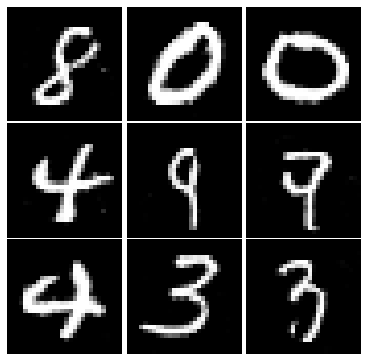

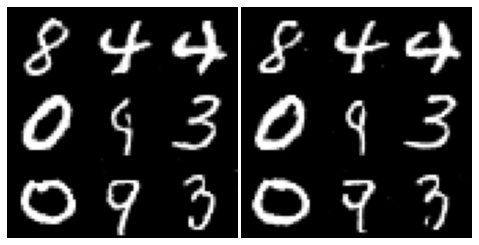

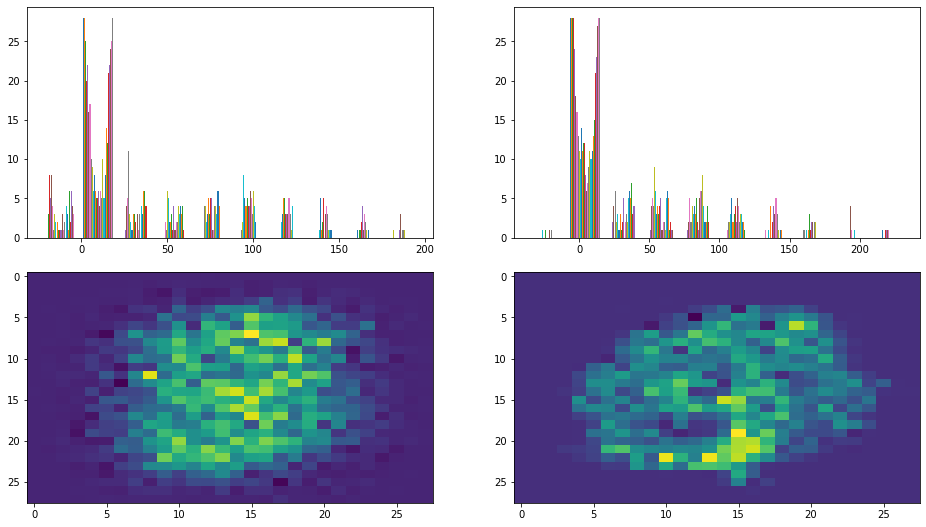

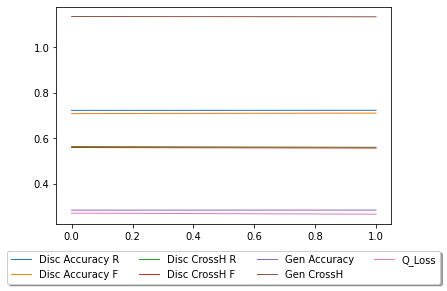

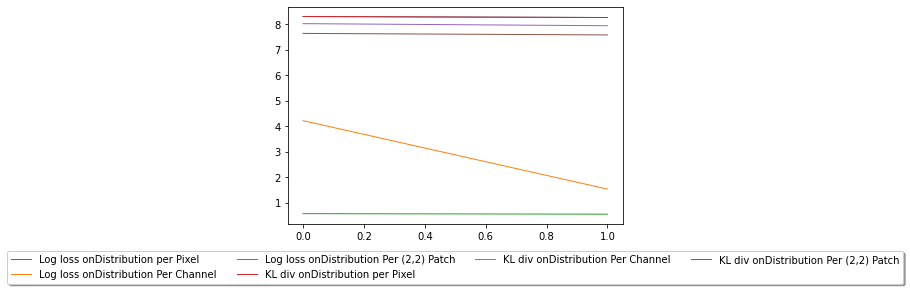

Time for epoch 39 is 449.8316297531128 sec


'\n309148.\n\n'

In [60]:
# With random weights initialization the accuracy on fake images is very high, due to low weights -> low weights output -> sigmoid -> 0 -> 0 is good for fake images.
# The discriminator won't learn how to classify real images, will just be resilient to the generaor -> from epoch 1 and on Accuracy on real images = 0
# Find measure of image quality - perhaps mean std per pixel in dataset and compute the probability of that

# Convert ln of loss in probability
# USE AVG/MAX POOLING for image smoothness

# Aggiungere grafico con le immagini generate e la probabilità assegnata dal dataset d'origine
# Fix the x axis of the graphs, otherwise thwy will look similar

# Add avg pooling as last layer - to smooth images coming out of the generator

# The log loss when you have conditioning cannot be computed conditioned_image vs entire original dataset. It won't match - > If the generated seed distribution is not equal to the dataset intrinsic distribution of classes
# LOG TO TENSORBOARD ALSO DISTRIBUTIONs DISPLAYED BY MATPLOT
# CHECK DISTRIBUTION ON NORMALIZED OR NOT IMAGES
# CHANGE HOW TO GEN EXTRA INPUTS OR BATCH WITH DIFFERENT SIZE FUCK UP

# Save to tensorboard THE DISTO PLOTS!!
# Plot the distribution as if 20x20 images
# Find a way to Introduce the variance in the image
# Add graphs of losses?

# image sum log loss uses the mean of the generated images to calculate the probability of that to be sampled on the real dist
# -> calculate the distance between the real dist and the generated image dist
# Rivedere se usare sum log loss o direttamente mean log loss (per pixel/channel etc)

# Add a part of the architecture trained on IQA dataset to help producing good results

## Distributions of pixel per class!! This can have an huge impact
# APplicare traslazioni/rotazioni alle immagini e vedere le distribuzioni
# Look into different architecture representation layers for the low-dimensional high-level features

# Add generator metrics
# Add custom metric for storing KL div, log loss
rlib()




EPOCHS = 40
#valid_dataset
image_save_path = path_to_TrackGAN + 'Generated Images/' + model_name +'/'

# Check if a checkpoint exists
if checkpoint_manager.latest_checkpoint:
  print("Restored from {}".format(checkpoint_manager.latest_checkpoint))
  _ = checkpoint.restore(checkpoint_manager.latest_checkpoint)



with tf.device('/device:GPU:0'):
  train_asses.train(training_dataset, EPOCHS, valid_dataset= None, starting_epoch= checkpoint.step.numpy(), summary_writer= summary_writer, generator= generator, gen_seed= noise_seed,
                    checkpoint_manager= checkpoint_manager, distributions= distributions, DEBUG= False, BATCH_SIZE= BATCH_SIZE,
                    image_save_path= image_save_path, model = GAN_Model)


'''
309148.

'''

In [58]:
# Restore latest checkpoint
if checkpoint_manager.latest_checkpoint:
  print("Restored from {}".format(checkpoint_manager.latest_checkpoint))
  _ = checkpoint.restore(checkpoint_manager.latest_checkpoint)


Restored from /content/drive/My Drive/Colab Notebooks/TrackGAN/training_checkpoints/InfoGAN D115k-G180k/tf_ckpts-39


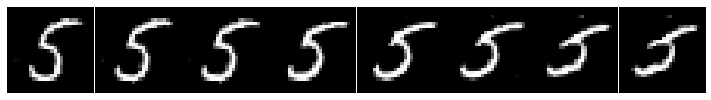

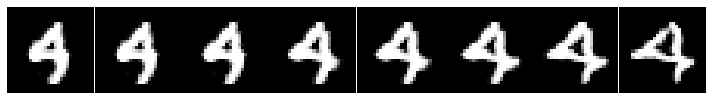

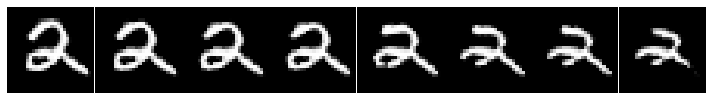

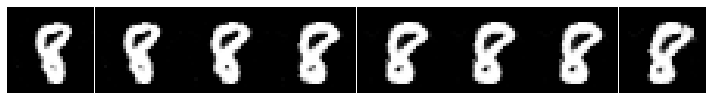

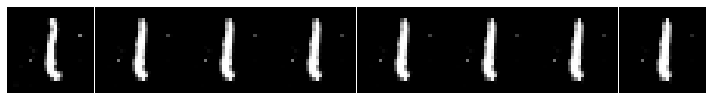

In [59]:
GAN_Model.sample_from_model(num_examples = 8)

In [ ]:
image_path = path_to_TrackGAN + 'Generated Images/' + model_name +'/'

anim_file = path_to_TrackGAN + 'Generated Images/' + model_name + '.gif'

image_utils.generate_GIF(image_path, anim_file)

In [ ]:
#!pip install  git+https://github.com/tensorflow/docs
#import tensorflow_docs.vis.embed as embed

embed.embed_file(anim_file)